In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyodbc

import warnings 
warnings.filterwarnings('ignore')


from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV


from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import RFE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


In [62]:
pyodbc.drivers()

['SQL Server',
 'SQL Server Native Client RDA 11.0',
 'ODBC Driver 17 for SQL Server',
 'Microsoft Access Driver (*.mdb, *.accdb)',
 'Microsoft Excel Driver (*.xls, *.xlsx, *.xlsm, *.xlsb)',
 'Microsoft Access Text Driver (*.txt, *.csv)',
 'Microsoft Access dBASE Driver (*.dbf, *.ndx, *.mdx)']

In [63]:
# Eshtablishing the connection :

connection = pyodbc.connect(
    Trusted_Connection = "Yes",
    Driver = "{ODBC Driver 17 for SQL Server}",
    Server = "LAPTOP-6FTSTUVL\SQLEXPRESS",
    Database = "Bank_Customer_Churn"
)

In [64]:
data = pd.read_sql_query("SELECT * FROM dbo.train", connection)
data.head()

#Close connection
connection.close()

In [65]:
data.head()

,customer_id,Name,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,...,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
0,fffe4300490044003600300030003800,Pattie Morrisey,18,F,XW0DQ7H,Village,Platinum Membership,2017-08-17,No,xxxxxxxx,...,300.630005,53005.250000,17.0,781.750000,Yes,Yes,No,Not Applicable,Products always in Stock,2
1,fffe43004900440032003100300035003700,Traci Peery,32,F,5K0N3X1,City,Premium Membership,2017-08-28,?,CID21329,...,306.339996,12838.379883,10.0,NaN,Yes,No,Yes,Solved,Quality Customer Care,1
2,fffe4300490044003100390032003600,Merideth Mcmeen,44,F,1F2TCL3,Town,No Membership,2016-11-11,Yes,CID12313,...,516.159973,21027.000000,22.0,500.690002,No,Yes,Yes,Solved in Follow-up,Poor Website,5
3,fffe43004900440036003000330031003600,Eufemia Cardwell,37,M,VJGJ33N,City,No Membership,2016-10-29,Yes,CID3793,...,53.270000,25239.560547,6.0,567.659973,No,Yes,Yes,Unsolved,Poor Website,5
4,fffe43004900440031003900350030003600,Meghan Kosak,31,F,SVZXCWB,City,No Membership,2017-09-12,No,xxxxxxxx,...,113.129997,24483.660156,16.0,663.059998,No,Yes,Yes,Solved,Poor Website,5


In [73]:
grouped = data.groupby('preferred_offer_types').agg(
    total_cust=('customer_id', 'count'),
    cust_joined_thr_ref=('joined_through_referral', lambda x: (x == 'Yes').sum()))

grouped['% of cust'] = (grouped['cust_joined_thr_ref'] * 100) / grouped['total_cust']

grouped

,total_cust,cust_joined_thr_ref,% of cust
preferred_offer_types,,,
Credit/Debit Card Offers,12274,5203,42.390419
Gift Vouchers/Coupons,12349,5201,42.116771
Without Offers,12081,5174,42.827580


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36992 entries, 0 to 36991
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_id                   36992 non-null  object 
 1   Name                          36992 non-null  object 
 2   age                           36992 non-null  int64  
 3   gender                        36992 non-null  object 
 4   security_no                   36992 non-null  object 
 5   region_category               36992 non-null  object 
 6   membership_category           36992 non-null  object 
 7   joining_date                  36992 non-null  object 
 8   joined_through_referral       36992 non-null  object 
 9   referral_id                   36992 non-null  object 
 10  preferred_offer_types         36704 non-null  object 
 11  medium_of_operation           36992 non-null  object 
 12  internet_option               36992 non-null  object 
 13  l

In [7]:
# Checking the shape of the data.
data.shape

(36992, 26)

In [8]:
# Checking missings in the data
data.isna().sum()

customer_id                        0
Name                               0
age                                0
gender                             0
security_no                        0
region_category                    0
membership_category                0
joining_date                       0
joined_through_referral            0
referral_id                        0
preferred_offer_types            288
medium_of_operation                0
internet_option                    0
last_visit_time                    0
last_visit_hour                    0
days_since_last_login              0
avg_time_spent                     0
avg_transaction_value              0
avg_frequency_login_days        3522
points_in_wallet                3443
used_special_discount              0
offer_application_preference       0
past_complaint                     0
complaint_status                   0
feedback                           0
churn_risk_score                   0
dtype: int64

In [9]:
# Since there are 3 columns with missing data and in only one column ("preferred_offer_types") missings can be dropped as it is very little
# like not even 1 percent of the population
# That's why we'll remove those observations from the data

data.dropna(subset=['preferred_offer_types'], axis=0, how='any', inplace=True, ignore_index = True)

In [10]:
# Now the shape of the data has changed.
data.shape

(36704, 26)

In [11]:
# Checking duplicates in the data
data.duplicated().sum()

0

In [12]:
# Checking missings in the data
data.isna().sum()

customer_id                        0
Name                               0
age                                0
gender                             0
security_no                        0
region_category                    0
membership_category                0
joining_date                       0
joined_through_referral            0
referral_id                        0
preferred_offer_types              0
medium_of_operation                0
internet_option                    0
last_visit_time                    0
last_visit_hour                    0
days_since_last_login              0
avg_time_spent                     0
avg_transaction_value              0
avg_frequency_login_days        3496
points_in_wallet                3416
used_special_discount              0
offer_application_preference       0
past_complaint                     0
complaint_status                   0
feedback                           0
churn_risk_score                   0
dtype: int64

In [13]:
# Basic distribution summary
print(data['avg_frequency_login_days'].describe())
print(data['points_in_wallet'].describe())

count    33208.000000
mean        15.974414
std          9.206895
min        -43.652702
25%          9.000000
50%         16.000000
75%         23.000000
max         73.061996
Name: avg_frequency_login_days, dtype: float64
count    33288.000000
mean       686.919871
std        193.947572
min       -760.661255
25%        616.075012
50%        697.665009
75%        763.955002
max       2069.069824
Name: points_in_wallet, dtype: float64


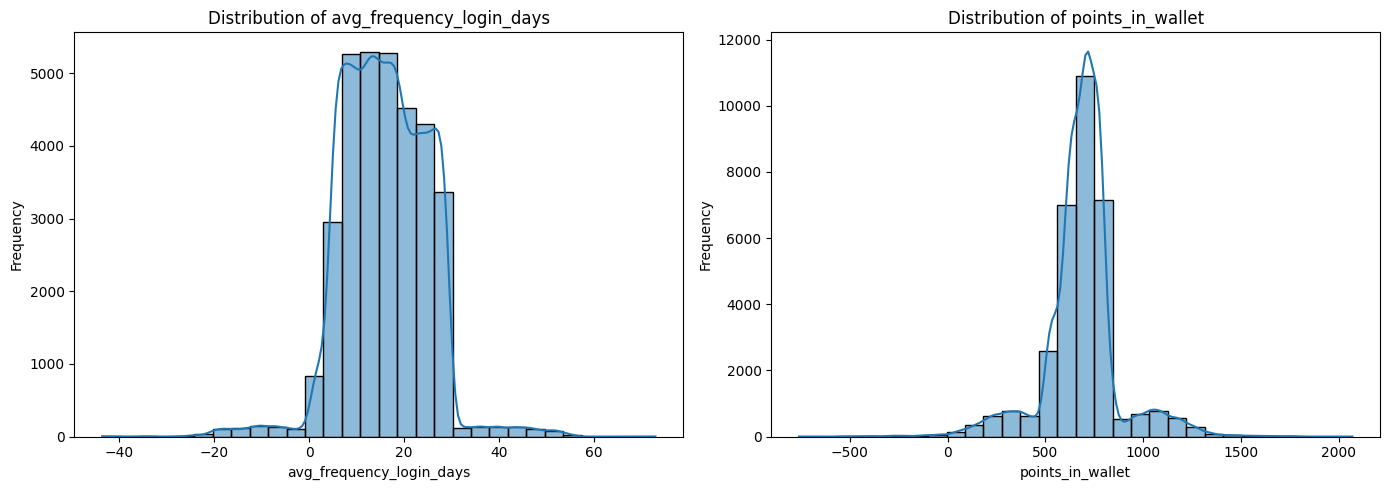

In [14]:
## Compare mean and median to check the skewness of the data.
# Since mean < median, the data is left skewed and we have to use median to fill the missing records.

fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 row, 2 columns

# Histogram for avg_frequency_login_days
sns.histplot(data['avg_frequency_login_days'], bins=30, kde=True, edgecolor='black', ax=axes[0])
axes[0].set_title('Distribution of avg_frequency_login_days')
axes[0].set_xlabel('avg_frequency_login_days')
axes[0].set_ylabel('Frequency')

# Histogram for points_in_wallet
sns.histplot(data['points_in_wallet'], bins=30, kde=True, edgecolor='black', ax=axes[1])
axes[1].set_title('Distribution of points_in_wallet')
axes[1].set_xlabel('points_in_wallet')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [15]:
# So the imputation plan should be like, we'll fill the average frequency login days column with Median and Points in wallet column with mean.
# Also, there are some negative records in the 1st chart. And days can't be negative. So we'll replace them as well.

median_val = data['avg_frequency_login_days'].median()
mean_val = data['points_in_wallet'].mean()

# replacing all missing and negative records with median value of the data.

data.loc[data['avg_frequency_login_days'] < 0, 'avg_frequency_login_days'] = pd.NA
data['avg_frequency_login_days'].fillna(median_val, inplace=True)

# replacing all missing records with mean value of the data.

data['points_in_wallet'].fillna(mean_val, inplace=True)

In [16]:
# Checking missings in the data
data.isna().sum()

customer_id                     0
Name                            0
age                             0
gender                          0
security_no                     0
region_category                 0
membership_category             0
joining_date                    0
joined_through_referral         0
referral_id                     0
preferred_offer_types           0
medium_of_operation             0
internet_option                 0
last_visit_time                 0
last_visit_hour                 0
days_since_last_login           0
avg_time_spent                  0
avg_transaction_value           0
avg_frequency_login_days        0
points_in_wallet                0
used_special_discount           0
offer_application_preference    0
past_complaint                  0
complaint_status                0
feedback                        0
churn_risk_score                0
dtype: int64

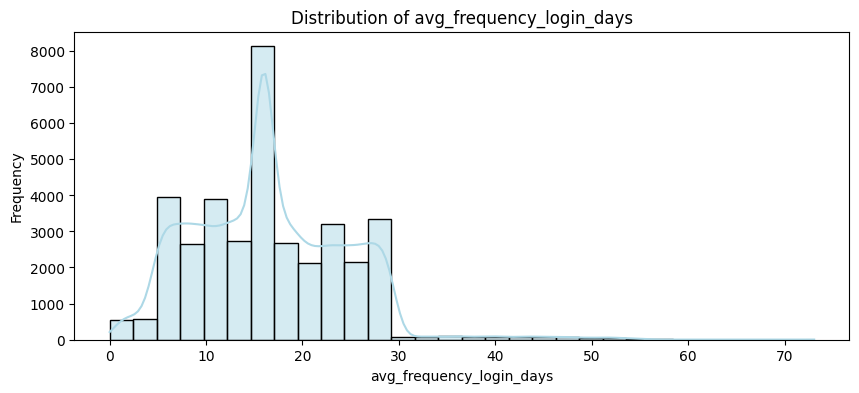

In [17]:
# avg_frequency_login_days distribution :

plt.figure(figsize=(10, 4))
sns.histplot(data['avg_frequency_login_days'],
             bins=30,
             kde=True,
             color='lightblue',
             edgecolor='black')
plt.title('Distribution of avg_frequency_login_days')
plt.xlabel('avg_frequency_login_days')
plt.ylabel('Frequency')
plt.show()

In [18]:
# Distribution of the column "avg_time_spent"

data['avg_time_spent'].describe()

count    36704.000000
mean       243.394279
std        398.020264
min      -2814.109131
25%         60.060001
50%        161.764999
75%        356.222504
max       3235.578613
Name: avg_time_spent, dtype: float64

In [19]:
# Replacing the missing and negative with median as the column's data is highly skewed.
# It has something around 1.7k negative records.

median_val = data[data['avg_time_spent'] >= 0]['avg_time_spent'].median()                        # 174.175 is the median value
data['avg_time_spent'] = data['avg_time_spent'].apply(lambda x: median_val if x < 0 else x)


In [20]:
# Convert to datetime
data['joining_date'] = pd.to_datetime(data['joining_date'], errors='coerce')


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36704 entries, 0 to 36703
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   customer_id                   36704 non-null  object        
 1   Name                          36704 non-null  object        
 2   age                           36704 non-null  int64         
 3   gender                        36704 non-null  object        
 4   security_no                   36704 non-null  object        
 5   region_category               36704 non-null  object        
 6   membership_category           36704 non-null  object        
 7   joining_date                  36704 non-null  datetime64[ns]
 8   joined_through_referral       36704 non-null  object        
 9   referral_id                   36704 non-null  object        
 10  preferred_offer_types         36704 non-null  object        
 11  medium_of_operation         

In [22]:
data.describe()

,age,joining_date,last_visit_hour,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,churn_risk_score
count,36704.000000,36704,36704.000000,36704.000000,36704.000000,36704.000000,36704.000000,36704.000000,36704.000000
mean,37.116391,2016-07-04 02:46:42.005231360,12.023703,-42.034819,287.114025,29275.529738,16.474582,686.919871,3.463410
min,10.000000,2015-01-01 00:00:00,0.000000,-999.000000,1.837399,800.460022,0.009208,-760.661255,-1.000000
25%,23.000000,2015-10-01 00:00:00,6.000000,8.000000,75.620003,14176.969727,11.000000,624.340027,3.000000
50%,37.000000,2016-07-05 00:00:00,12.000000,12.000000,174.174995,27563.714844,16.000000,686.919871,4.000000
75%,51.000000,2017-04-06 00:00:00,18.000000,16.000000,356.222504,40862.024414,22.000000,757.010010,5.000000
max,64.000000,2017-12-31 00:00:00,24.000000,26.000000,3235.578613,99914.046875,73.061996,2069.069824,5.000000
std,15.871235,NaN,6.934908,229.069357,324.872809,19448.156511,7.885463,184.701700,1.409707


## Exploratory Data Analysis

In [23]:
# Additional Data Information:

print("\nAdditional Statistics:")
print(f"Total number of customers: {data['customer_id'].nunique()}")
print(f"Total number of membership category: {data['membership_category'].nunique()}")
print(f"Total number of offer types: {data['preferred_offer_types'].nunique()}")
print(f"Total number of region category: {data['region_category'].nunique()}")
print(f"Date range: from {data['joining_date'].min()} to {data['joining_date'].max()}")
print(f"Total number of unique feedback: {data['feedback'].nunique()}")
print(f"Total number of unique complaint status: {data['complaint_status'].nunique()}")



Additional Statistics:
Total number of customers: 36704
Total number of membership category: 6
Total number of offer types: 3
Total number of region category: 4
Date range: from 2015-01-01 00:00:00 to 2017-12-31 00:00:00
Total number of unique feedback: 9
Total number of unique complaint status: 5


In [24]:
data.columns

Index(['customer_id', 'Name', 'age', 'gender', 'security_no',
       'region_category', 'membership_category', 'joining_date',
       'joined_through_referral', 'referral_id', 'preferred_offer_types',
       'medium_of_operation', 'internet_option', 'last_visit_time',
       'last_visit_hour', 'days_since_last_login', 'avg_time_spent',
       'avg_transaction_value', 'avg_frequency_login_days', 'points_in_wallet',
       'used_special_discount', 'offer_application_preference',
       'past_complaint', 'complaint_status', 'feedback', 'churn_risk_score'],
      dtype='object')

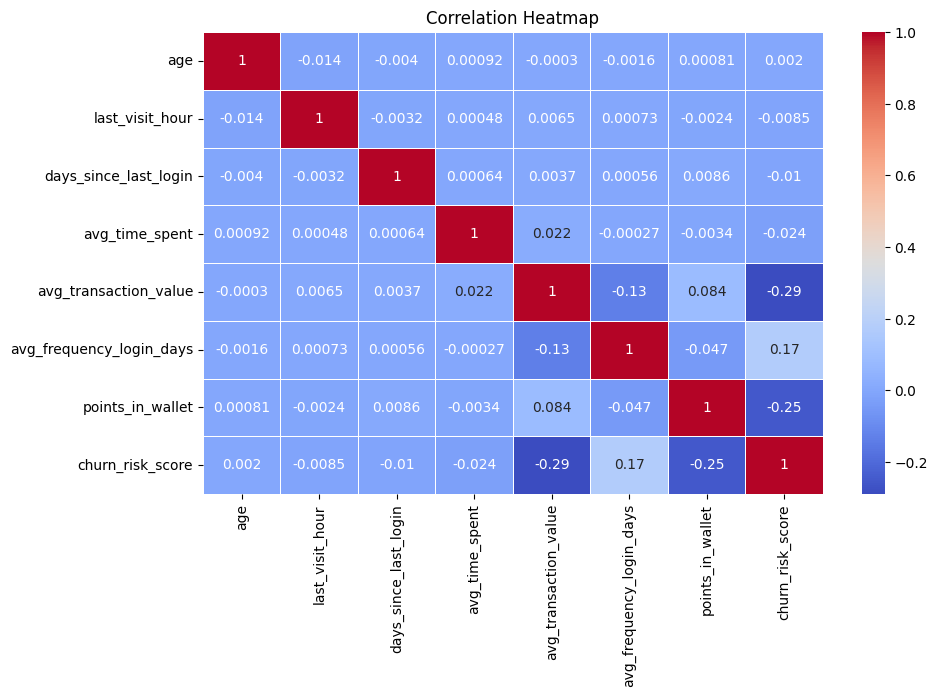

In [25]:
# Correlation among columns:

numeric_columns = data.select_dtypes(include=[np.number]).columns
correlation_matrix = data[numeric_columns].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [26]:
# Target variable description:
print(data['churn_risk_score'].value_counts())
target_des = data['churn_risk_score'].describe()
target_des

churn_risk_score
 3    10339
 4    10098
 5     9757
 2     2719
 1     2640
-1     1151
Name: count, dtype: int64


count    36704.000000
mean         3.463410
std          1.409707
min         -1.000000
25%          3.000000
50%          4.000000
75%          5.000000
max          5.000000
Name: churn_risk_score, dtype: float64

In [27]:
# Extracting the month of joining :

data['joining_month'] = data['joining_date'].dt.month

In [28]:
data.columns

Index(['customer_id', 'Name', 'age', 'gender', 'security_no',
       'region_category', 'membership_category', 'joining_date',
       'joined_through_referral', 'referral_id', 'preferred_offer_types',
       'medium_of_operation', 'internet_option', 'last_visit_time',
       'last_visit_hour', 'days_since_last_login', 'avg_time_spent',
       'avg_transaction_value', 'avg_frequency_login_days', 'points_in_wallet',
       'used_special_discount', 'offer_application_preference',
       'past_complaint', 'complaint_status', 'feedback', 'churn_risk_score',
       'joining_month'],
      dtype='object')

In [29]:
# Removing the unnecessory columns from the data.

data.drop(columns=['customer_id', 'Name', 'security_no', 'joining_date', 'referral_id', 'last_visit_time'], axis=1, inplace=True)

In [30]:
data.columns

Index(['age', 'gender', 'region_category', 'membership_category',
       'joined_through_referral', 'preferred_offer_types',
       'medium_of_operation', 'internet_option', 'last_visit_hour',
       'days_since_last_login', 'avg_time_spent', 'avg_transaction_value',
       'avg_frequency_login_days', 'points_in_wallet', 'used_special_discount',
       'offer_application_preference', 'past_complaint', 'complaint_status',
       'feedback', 'churn_risk_score', 'joining_month'],
      dtype='object')

In [31]:
# Determining X (Features) and y (Target) :

X=data.drop(columns=['churn_risk_score'])
y=data['churn_risk_score']

# Outliers:

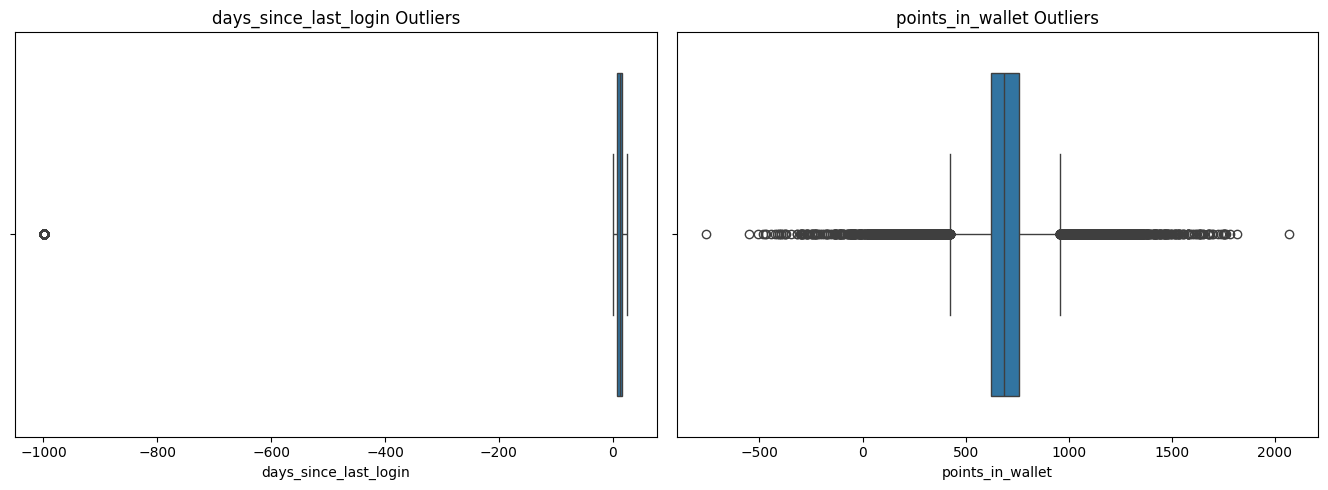

In [32]:
# Checking the outliers :

plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
sns.boxplot(x=data['days_since_last_login'])
plt.title('days_since_last_login Outliers')

plt.subplot(1, 3, 2)
sns.boxplot(x=data['points_in_wallet'])
plt.title('points_in_wallet Outliers')

plt.tight_layout()
plt.show()


In [33]:
data['points_in_wallet'].describe(percentiles = [0.01,0.99])    

# But we do not treat this outlier, because negative amount means the customer is in debt. and since this feature is less than 1%, we can't remove it.

count    36704.000000
mean       686.919871
std        184.701700
min       -760.661255
1%         125.256929
50%        686.919871
99%       1246.630663
max       2069.069824
Name: points_in_wallet, dtype: float64

In [34]:
data['days_since_last_login'].describe(percentiles = [0.01,0.99])

# Here also we will not treat the outliers as -999 means that customer has logged in today itself
# But we will replace -999 with 0 so that it makes some sense as per the calculation.

count    36704.000000
mean       -42.034819
std        229.069357
min       -999.000000
1%        -999.000000
50%         12.000000
99%         24.000000
max         26.000000
Name: days_since_last_login, dtype: float64

In [35]:
data['days_since_last_login'] = data['days_since_last_login'].replace(-999, 0)

In [36]:
data['days_since_last_login'].describe(percentiles = [0.01,0.99])


count    36704.000000
mean        12.074052
std          6.141908
min          0.000000
1%           0.000000
50%         12.000000
99%         24.000000
max         26.000000
Name: days_since_last_login, dtype: float64

In [37]:
cat_cols = data.select_dtypes(include=['object'])
cat_cols

,gender,region_category,membership_category,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback
0,F,Village,Platinum Membership,No,Gift Vouchers/Coupons,?,Wi-Fi,Yes,Yes,No,Not Applicable,Products always in Stock
1,F,City,Premium Membership,?,Gift Vouchers/Coupons,Desktop,Mobile_Data,Yes,No,Yes,Solved,Quality Customer Care
2,F,Town,No Membership,Yes,Gift Vouchers/Coupons,Desktop,Wi-Fi,No,Yes,Yes,Solved in Follow-up,Poor Website
3,M,City,No Membership,Yes,Gift Vouchers/Coupons,Desktop,Mobile_Data,No,Yes,Yes,Unsolved,Poor Website
4,F,City,No Membership,No,Credit/Debit Card Offers,Smartphone,Mobile_Data,No,Yes,Yes,Solved,Poor Website
...,...,...,...,...,...,...,...,...,...,...,...,...
36699,F,Unknown,Basic Membership,No,Credit/Debit Card Offers,Desktop,Wi-Fi,No,Yes,Yes,No Information Available,No reason specified
36700,F,Town,Basic Membership,No,Without Offers,Smartphone,Wi-Fi,Yes,No,No,Not Applicable,Poor Customer Service
36701,F,Unknown,Basic Membership,Yes,Gift Vouchers/Coupons,Desktop,Wi-Fi,No,Yes,Yes,Unsolved,Poor Website
36702,M,Village,Platinum Membership,No,Gift Vouchers/Coupons,Smartphone,Mobile_Data,Yes,Yes,No,Not Applicable,No reason specified


## Categorical columns encoding :

In [38]:
ohe = OneHotEncoder(drop='first')
ohe = ohe.fit(cat_cols)

In [39]:
transformed_data = ohe.transform(cat_cols)

In [40]:
cat_data = pd.DataFrame(transformed_data.toarray(), columns=ohe.get_feature_names_out())
cat_data

,gender_M,gender_Unknown,region_category_Town,region_category_Unknown,region_category_Village,membership_category_Gold Membership,membership_category_No Membership,membership_category_Platinum Membership,membership_category_Premium Membership,membership_category_Silver Membership,...,complaint_status_Solved in Follow-up,complaint_status_Unsolved,feedback_Poor Customer Service,feedback_Poor Product Quality,feedback_Poor Website,feedback_Products always in Stock,feedback_Quality Customer Care,feedback_Reasonable Price,feedback_Too many ads,feedback_User Friendly Website
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36699,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36700,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36701,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
36702,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
num_data = data[data.columns.difference(data.select_dtypes(include=['object']).columns)]
num_data

,age,avg_frequency_login_days,avg_time_spent,avg_transaction_value,churn_risk_score,days_since_last_login,joining_month,last_visit_hour,points_in_wallet
0,18,17.0,300.630005,53005.250000,2,17,8,16,781.750000
1,32,10.0,306.339996,12838.379883,1,16,8,13,686.919871
2,44,22.0,516.159973,21027.000000,5,14,11,23,500.690002
3,37,6.0,53.270000,25239.560547,5,11,10,16,567.659973
4,31,16.0,113.129997,24483.660156,5,20,9,16,663.059998
...,...,...,...,...,...,...,...,...,...
36699,46,6.0,174.174995,27277.679688,4,2,9,4,639.510010
36700,29,28.0,174.174995,11069.709961,5,13,6,23,527.989990
36701,23,16.0,154.940002,38127.558594,4,12,9,4,680.469971
36702,53,20.0,482.609985,2378.860107,3,15,6,10,197.264420


In [42]:
# Checking both the numerical and encoded categorical columns shape and concat them.

print(cat_data.shape)
print(num_data.shape)

final_data = pd.concat([cat_data, num_data], axis=1)
final_data

(36704, 34)
(36704, 9)


,gender_M,gender_Unknown,region_category_Town,region_category_Unknown,region_category_Village,membership_category_Gold Membership,membership_category_No Membership,membership_category_Platinum Membership,membership_category_Premium Membership,membership_category_Silver Membership,...,feedback_User Friendly Website,age,avg_frequency_login_days,avg_time_spent,avg_transaction_value,churn_risk_score,days_since_last_login,joining_month,last_visit_hour,points_in_wallet
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,18,17.0,300.630005,53005.250000,2,17,8,16,781.750000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,32,10.0,306.339996,12838.379883,1,16,8,13,686.919871
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,44,22.0,516.159973,21027.000000,5,14,11,23,500.690002
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,37,6.0,53.270000,25239.560547,5,11,10,16,567.659973
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,31,16.0,113.129997,24483.660156,5,20,9,16,663.059998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36699,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,46,6.0,174.174995,27277.679688,4,2,9,4,639.510010
36700,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,29,28.0,174.174995,11069.709961,5,13,6,23,527.989990
36701,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,23,16.0,154.940002,38127.558594,4,12,9,4,680.469971
36702,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,53,20.0,482.609985,2378.860107,3,15,6,10,197.264420


## Data balancing check :

In [43]:
y.value_counts(normalize=True)

churn_risk_score
 3    0.281686
 4    0.275120
 5    0.265829
 2    0.074079
 1    0.071927
-1    0.031359
Name: proportion, dtype: float64

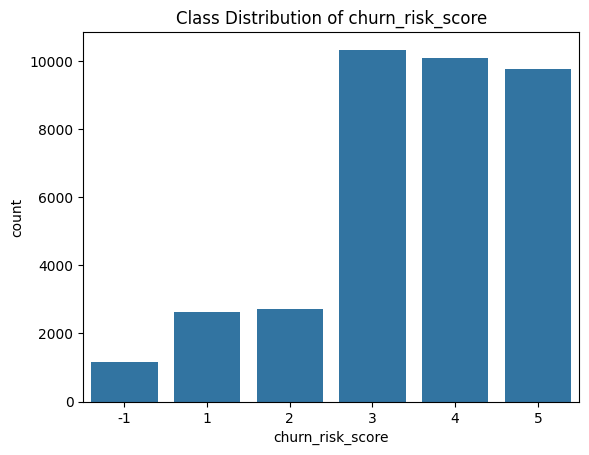

In [44]:
sns.countplot(x='churn_risk_score', data=data)
plt.title("Class Distribution of churn_risk_score")
plt.show()

In [45]:
# Separating features and target variables:

X = final_data.drop('churn_risk_score', axis=1)
y = final_data['churn_risk_score']


## Feature Selection :

In [46]:
# Feature Selection :

selector = SelectKBest(score_func=f_classif, k=10) 
X_selected = selector.fit_transform(X, y)

selected_columns = X.columns[selector.get_support()]
print("Selected Features:", selected_columns.tolist())

Selected Features: ['membership_category_No Membership', 'membership_category_Platinum Membership', 'membership_category_Premium Membership', 'membership_category_Silver Membership', 'feedback_Products always in Stock', 'feedback_Quality Customer Care', 'feedback_Reasonable Price', 'feedback_User Friendly Website', 'avg_transaction_value', 'points_in_wallet']


In [47]:
# Feature Selection :

rfe = RFE(estimator=LogisticRegression(max_iter=1000), n_features_to_select=10)
rfe.fit(X, y)
selected_features = X.columns[rfe.support_]
print("RFE Selected Features:", selected_features.tolist())

RFE Selected Features: ['membership_category_Gold Membership', 'membership_category_No Membership', 'membership_category_Platinum Membership', 'membership_category_Premium Membership', 'membership_category_Silver Membership', 'feedback_Poor Product Quality', 'feedback_Products always in Stock', 'feedback_Quality Customer Care', 'feedback_Reasonable Price', 'feedback_User Friendly Website']


In [48]:
# Combining the both lists:

selected_features = list(set(list(selected_columns) + list(selected_features)))
X_new = X[selected_features]
X_new.head(3)

,feedback_Poor Product Quality,feedback_Reasonable Price,membership_category_Premium Membership,feedback_Products always in Stock,membership_category_Platinum Membership,feedback_User Friendly Website,membership_category_Gold Membership,membership_category_No Membership,points_in_wallet,feedback_Quality Customer Care,avg_transaction_value,membership_category_Silver Membership
0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,781.750000,0.0,53005.250000,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,686.919871,1.0,12838.379883,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,500.690002,0.0,21027.000000,0.0


In [49]:
# Map -1 → 0, 1 → 1, 2 → 2, etc. Because -1 is giving error as xgb does not take target as negative.
y = y.replace({-1: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5})

## Splitting the data for training and validating the model :

In [50]:
# Stratified train-test split : due to little imbalanced target variable

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, stratify=y, random_state=42)

## Balancing Of The Training Dataset:

In [51]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Different kinds of model training starts :

In [52]:
# Model Training : Logistic Regression

log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, class_weight='balanced')
log_reg.fit(X_train_smote, y_train_smote)

LogisticRegression(class_weight='balanced', max_iter=1000,
                   multi_class='multinomial')

In [53]:
y_pred_log = log_reg.predict(X_test)

In [54]:
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.03      0.14      0.04       230
           1       0.56      0.98      0.71       528
           2       0.89      0.30      0.44       544
           3       0.93      0.55      0.69      2068
           4       0.48      0.53      0.50      2020
           5       0.66      0.54      0.59      1951

    accuracy                           0.54      7341
   macro avg       0.59      0.50      0.50      7341
weighted avg       0.68      0.54      0.58      7341



## Model Training: Random Forest - Parallel method of training

In [55]:
rfc = RandomForestClassifier(class_weight='balanced', random_state=42)
rfc.fit(X_train_smote, y_train_smote)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [56]:
# Model Evaluation

y_pred = rfc.predict(X_test)
print("Random Forest Classifier Report:")
print(classification_report(y_test, y_pred))

Random Forest Classifier Report:
              precision    recall  f1-score   support

           0       0.05      0.02      0.03       230
           1       0.71      0.77      0.74       528
           2       0.75      0.73      0.74       544
           3       0.87      0.91      0.89      2068
           4       0.64      0.65      0.65      2020
           5       0.72      0.73      0.72      1951

    accuracy                           0.74      7341
   macro avg       0.63      0.63      0.63      7341
weighted avg       0.72      0.74      0.73      7341



## Model Evaluation : XGBoost - Sequential method of training

In [58]:
xgb = XGBClassifier()
xgb.fit(X_train_smote, y_train_smote)

y_pred_xgb = xgb.predict(X_test)

print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.05      0.00      0.01       230
           1       0.71      0.77      0.74       528
           2       0.75      0.71      0.73       544
           3       0.87      0.91      0.89      2068
           4       0.72      0.57      0.64      2020
           5       0.70      0.88      0.78      1951

    accuracy                           0.76      7341
   macro avg       0.63      0.64      0.63      7341
weighted avg       0.74      0.76      0.74      7341



In [59]:
# Hyperparameter tuning :

param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'max_leaves': [50, 75, 100, 150],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0]
}

grid_xgb = GridSearchCV(xgb, param_grid=param_grid_xgb, cv=5, n_jobs=-1)
grid_xgb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=Non...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 5, 7],
                         'max_leaves': [50, 75, 100, 150],
                         'n_estimators': [100, 200], 'subsample': [0.8, 1.0]})

In [60]:
# After tuning model evaluation :

best_xgb = grid_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

print("Best Parameters:", grid_xgb.best_params_)
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))

Best Parameters: {'learning_rate': 0.3, 'max_depth': 3, 'max_leaves': 50, 'n_estimators': 100, 'subsample': 1.0}
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       230
           1       0.70      0.87      0.77       528
           2       0.82      0.68      0.74       544
           3       0.89      0.89      0.89      2068
           4       0.75      0.54      0.63      2020
           5       0.69      0.95      0.80      1951

    accuracy                           0.77      7341
   macro avg       0.64      0.66      0.64      7341
weighted avg       0.75      0.77      0.75      7341



# Final tuned XGBoost Classifire model will be like :

In [74]:
xgbf = XGBClassifier(n_estimators= 100, learning_rate= 0.3, max_depth= 3, max_leaves= 50, subsample= 1.0, n_jobs=-1)
xgbf.fit(X_train, y_train)

y_pred_xgbf = xgbf.predict(X_test)

print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgbf))

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       230
           1       0.70      0.87      0.77       528
           2       0.82      0.68      0.74       544
           3       0.89      0.89      0.89      2068
           4       0.75      0.54      0.63      2020
           5       0.69      0.95      0.80      1951

    accuracy                           0.77      7341
   macro avg       0.64      0.66      0.64      7341
weighted avg       0.75      0.77      0.75      7341



### Why Scaling is Not Needed:
**Tree models (like Random Forest and XGBoost) do not use distance metrics (unlike k-NN, SVM, Logistic Regression).**

**They just split data based on feature thresholds. Whether the feature is 5 or 5000 doesn't matter to the split decision.**

# Best Model: LinearRegression ¶
**Based on the evaluation metrics, XGBoost is the best model for predicting demand in the retail store dataset. It provides:**

The highest Accuracy Score 0.77

Therefore, XGBoost Classifier is the most reliable choice for this dataset.

In [61]:
import pickle

#bundle = {'model': xgbf, 'encoder': ohe, "selected_features": selected_features}
#with open("E:\AnalytixLAB Internship\Project 6 Materials\Bank Customer Churn Data\XGBClass_model_bundle.pkl", "wb") as file:
#    pickle.dump(bundle, file)